In [1]:
# Import all the required packages

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Change directory to data location
%cd ~/Documents/DSE/dmysoren/DSE200/data/economics

/Users/Deepthi/Documents/DSE/dmysoren/DSE200/data/economics


In [3]:
## 1. Read each of the csv files iteratively

# Get a list of files in the current directory
files = !ls

# Create an empty dict
data = {}

# Iterate through the file names and read into the dictionary 'data'
for filename in files:
    code = filename.replace('.csv','')
    data[code] = pd.read_csv(filename)

In [4]:
## 2. Merge all of the data into a single dataframe by building a dictionary where the keys are the codes 
## and the values are the Series from each downloaded file

# Create an empty dict to create indexed dataframes
data_indexed = {}

# Create index on 'DATE'
for key,value in data.iteritems():
    data_indexed[key] = data[key].set_index('DATE')

# Create merged_data with all the value columns and 'DATE' from all the datasets
merged_data = pd.concat(data_indexed, axis = 1)

## Printing the sample of merged_data
merged_data.head()

,AAA,BAA,CPILFESL,GDPC1,GS1,GS10,INDPRO,UNRATE
,VALUE,VALUE,VALUE,VALUE,VALUE,VALUE,VALUE,VALUE
1919-01-01,5.35,7.12,NaN,NaN,NaN,NaN,4.8582,NaN
1919-02-01,5.35,7.20,NaN,NaN,NaN,NaN,4.6435,NaN
1919-03-01,5.39,7.15,NaN,NaN,NaN,NaN,4.5092,NaN
1919-04-01,5.44,7.23,NaN,NaN,NaN,NaN,4.5898,NaN
1919-05-01,5.39,7.09,NaN,NaN,NaN,NaN,4.6166,NaN


In [5]:
## 3. Construct the Term and Default premia series using basic math on the series, and mmerge the resulting series using JOIN operation. 
## HINT: term_premium = merged_data[’GS10’] - merged_data[’GS1’] and default_premium = merged_data[’BAA’] - merged_data[’AAA’]

term_premium = merged_data['GS10'] - merged_data['GS1'] 
default_premium = merged_data['BAA'] - merged_data['AAA']

term_premium.rename(columns = {'VALUE':'term_premium'}, inplace = True)
default_premium.rename(columns = {'VALUE':'default_premium'}, inplace = True)

merged_data2 = (merged_data.join(term_premium)).join(default_premium)

## Printing the sample data after merging new columns 'term_premium' and 'default_premium'
merged_data2.head()

,"(AAA, VALUE)","(BAA, VALUE)","(CPILFESL, VALUE)","(GDPC1, VALUE)","(GS1, VALUE)","(GS10, VALUE)","(INDPRO, VALUE)","(UNRATE, VALUE)",term_premium,default_premium
1919-01-01,5.35,7.12,NaN,NaN,NaN,NaN,4.8582,NaN,NaN,1.77
1919-02-01,5.35,7.20,NaN,NaN,NaN,NaN,4.6435,NaN,NaN,1.85
1919-03-01,5.39,7.15,NaN,NaN,NaN,NaN,4.5092,NaN,NaN,1.76
1919-04-01,5.44,7.23,NaN,NaN,NaN,NaN,4.5898,NaN,NaN,1.79
1919-05-01,5.39,7.09,NaN,NaN,NaN,NaN,4.6166,NaN,NaN,1.70


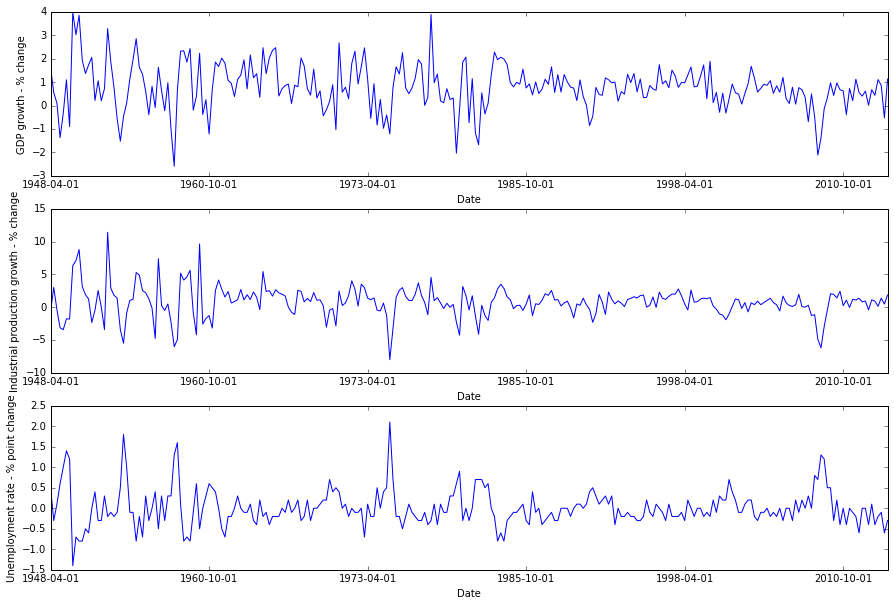

In [6]:
## 4. Process the data
## - dropping the rows with null values
##- Output data regularly to see if they are following regular format. Use pandas.series.pct_change wherever necessary

# Drop unnecessary columns and created a new data set
merged_data3 = merged_data.drop(['AAA','BAA','GS10','GS1','CPILFESL'],axis=1)

# Create a quarterly dataset by dropping NaN 
# (Although UNRATE is at a monthly level, for the purposes of analysis, only first month of the quarter is used)
qrtly = merged_data3.dropna()

# NOTE: INDRPRO is said to be quarterly data in the description (although data is populated at monthly level)
# So Assuming that beginning of the quarter has the correct read the following approach is taken

## Calculating percentage changes for GDPC1 and INDPRO
sel_col = ['GDPC1','INDPRO']
growth_rates = qrtly[sel_col].pct_change()

## Multiplying GDPC1 and INDPRO by 100 to get percent
growth_rates = growth_rates*100

## Since Unrate is already a percentage, i'm calculating difference.
sel_col2 = ['UNRATE']
growth_rates2 = qrtly[sel_col2].diff()

## Note: unnemployment difference is not multiplied by 100 as we need percentage point change

## Create a final dataset with necessary columns which can be used to plot
get_list = [growth_rates,growth_rates2]
to_plot = pd.concat(get_list, axis = 1)


# Removing the first row with NaN which is a result of pct_change and diff functions
to_plot = to_plot.dropna()


## 5. Plot ’GDP_growth’,’IP_growth’ and 'Unemp_rate' a a function of time and draw inferences. 
## Note: Here I have plotted all the three in separate graphs to ensure that the graph doesn't look cluttered. 
## Here, all the three graphs have their x-axes in sync so the variation in data can be read easily
## We can use twinx to plot secondary axes if needed

fig, axs = plt.subplots(3,1)

(to_plot[('GDPC1','VALUE')]).plot(ax = axs[0], figsize = (15,10))
axs[0].set_ylabel('GDP growth - % change')
axs[0].set_xlabel('Date')

(to_plot[('INDPRO','VALUE')]).plot(ax = axs[1], y = 'indpro_growth')
axs[1].set_ylabel('Industrial production growth - % change')
axs[1].set_xlabel('Date')

to_plot[('UNRATE','VALUE')].plot(ax = axs[2], y = 'unemp_rate')
axs[2].set_ylabel('Unemployment rate - % point change')
axs[2].set_xlabel('Date')


### Inference from the graphs:
### The graphs clearly show the relationship among Unemployment rate, Industrial production and GDP growth.
### An increase in Unemployment impacts the growth in industrial production and GDP growth.
### Hence, maintaining a good industrial production and employment rate are crucial to maintain GDP growth.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x108c5a7d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x109dc0310>]], dtype=object)

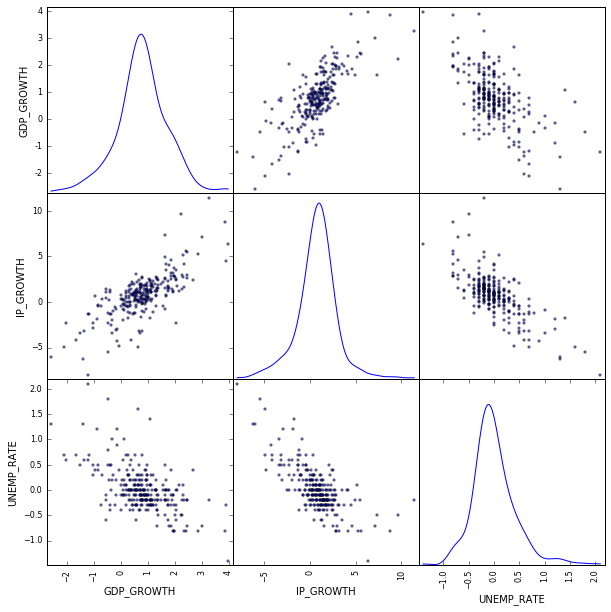

In [7]:
## 6. Use pandas function scatter_matrix to generate scatter plots of ’GDP_growth’,’IP_growth’ and 'Unemp_rate' 
## in a mmatrix form with kernel density plots along the diagonals.


df = pd.DataFrame({'GDP_GROWTH':to_plot[('GDPC1','VALUE')],'IP_GROWTH':to_plot[('INDPRO','VALUE')],'UNEMP_RATE':to_plot[('UNRATE','VALUE')]})

pd.scatter_matrix(df, diagonal='kde', figsize = (10,10))

## The scatter matrix clearly shows the relationship between the three metrics 'GDP_Growth', 'IP_Growth' and 'Unemp_rate'
## GDP_Growth is directly proportional to IP_growth implying GDP improves with improvemnt in industrial production
## However, IP_growth and Unemp_rate are inversely proportional which in turn affects the GDP.
## So, you can infer that GDP_growth is dependent on IP_growth which impacts the unemployment rates. 
## But in economics it is difficult to talk about causal and effect. Because, a poor GDP can result from an unknown factor
## Which might in turn impact the IP_growth and unemployment rates.